# Unsupervised Models

1) Autoencoders

In [1]:
#imports
import os
import psutil
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from typing import Dict, List, Tuple
from dataset.data import Dataset
from dataset.nfv2 import load_data
from numpy.typing import NDArray
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, matthews_corrcoef, roc_auc_score
keras = tf.keras
from keras.models import Model, load_model
from keras.layers import Input, Dropout, Dense, Lambda
from keras import optimizers
from keras import backend as K

# Enable determinsim
SEED = 1138

tf.keras.utils.set_random_seed(SEED)  # sets seeds for base-python, numpy and tf
tf.config.experimental.enable_op_determinism()

# CIC-IDS2017 DATASET

In [2]:
cicids: Tuple[Dataset, Dataset] = load_data("data/sampled/cicids_sampled.csv.gz", seed=SEED, n_partition=1, only_benign=False) # type: ignore

cicids_train, cicids_test = cicids
#print(cicids_train.X, cicids_train.y)

<Axes: >

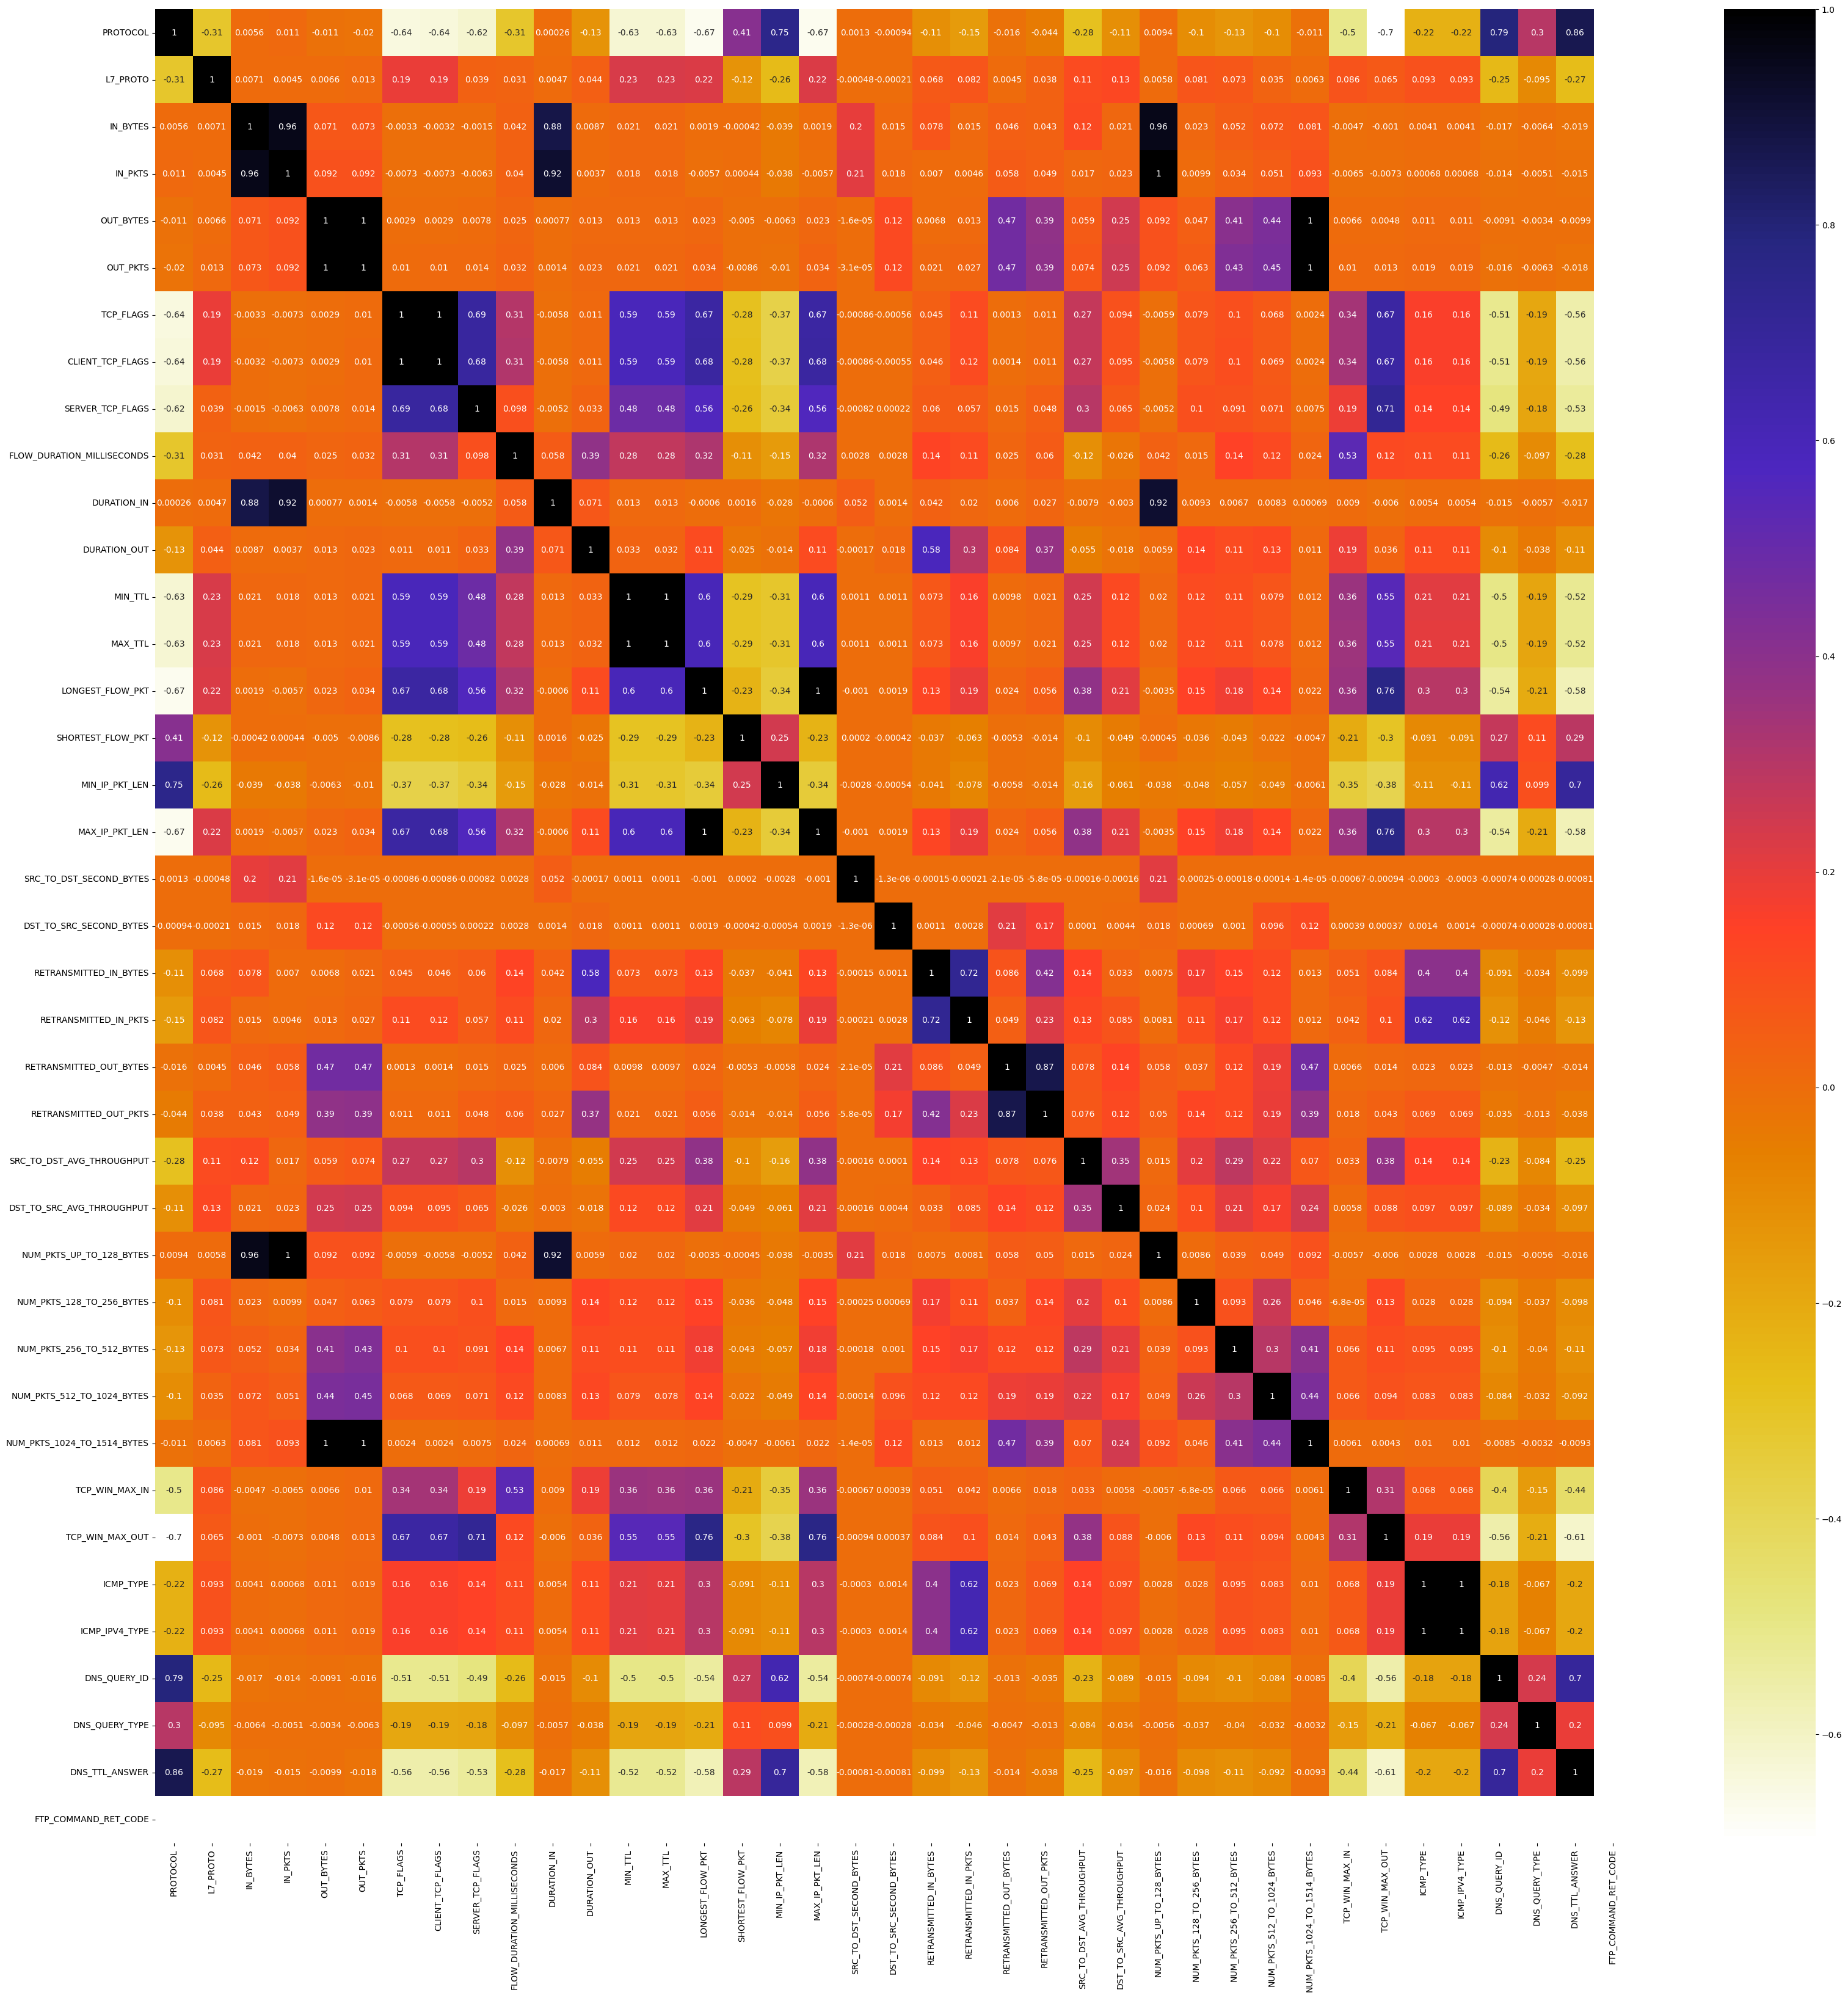

In [3]:
import seaborn as sns
#Using Pearson Correlation
plt.figure(figsize=(39,39))
cor = cicids_train.X.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
#plt.show()

In [4]:
# with the following function we can select highly correlated features
# it will remove the first feature that is correlated with anything other feature

def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [5]:
corr_features = correlation(cicids_train.X, 0.9)
print(len(set(corr_features)))
corr_features

9


{'CLIENT_TCP_FLAGS',
 'DURATION_IN',
 'ICMP_IPV4_TYPE',
 'IN_PKTS',
 'MAX_IP_PKT_LEN',
 'MAX_TTL',
 'NUM_PKTS_1024_TO_1514_BYTES',
 'NUM_PKTS_UP_TO_128_BYTES',
 'OUT_PKTS'}

In [6]:
'''cicids_train.X.drop(corr_features,axis=1)
cicids_test.X.drop(corr_features,axis=1)'''

label_series = cicids_train[1]

count_0 = label_series.value_counts()[0]
count_1 = label_series.value_counts()[1]

print("Count of 0 entries:", count_0)
print("Count of 1 entries:", count_1)
print(count_0/(count_0+count_1))



Count of 0 entries: 704499
Count of 1 entries: 95501
0.88062375


# Autoencoders


In [4]:
from keras import regularizers
from scipy.stats import norm

def create_model(num_features):
    """
    Creates a deep autoencoder to process tabular data with the total number of features represented by num_features.
    """
    model = tf.keras.models.Sequential([
        Input(shape=(num_features,)),
        Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        Dense(num_features, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01))
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss="mean_squared_error")
    
    return model


class BasicAutoencoderClassifier:
    
    def __init__(self, x_train, y_train, x_test, y_test):
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.model = create_model(x_train.shape[1])
        self.threshold = None
    
    def fit(self):
        start = time()
        cpu_usage = psutil.cpu_percent(interval= None)
        history = self.model.fit(
            self.x_train,
            self.x_train,
            batch_size=256,
            shuffle=True,
            epochs=10
        )
        training_time_cicids = time()-start 
        cpu_usage_cicids = cpu_usage
        '''reconstruction_losses = self.calculate_reconstruction_loss(self.x_train)
        count_0 = self.y_train.value_counts()[0]
        count_1 = self.y_train.value_counts()[1]
        self.threshold = np.quantile(reconstruction_losses, count_1/(count_0+count_1))'''
        reconstruction_losses = self.calculate_reconstruction_loss(self.x_train)
        count_0 = self.y_train.value_counts()[0]
        count_1 = self.y_train.value_counts()[1]
        
        # Calculate threshold using α% abnormality
        alpha = count_1 / (count_0 + count_1)
        mean_reconstruction_error = np.mean(reconstruction_losses)
        std_reconstruction_error = np.std(reconstruction_losses)
        z_value = norm.ppf(1 - alpha)
        threshold = mean_reconstruction_error + z_value * std_reconstruction_error
        self.threshold = threshold

        # Plot reconstruction losses with frequency
        plt.figure(figsize=(8, 6))
        plt.hist(reconstruction_losses[self.y_train == 0], bins=50, color='green', alpha=0.5, label='Normal')
        plt.hist(reconstruction_losses[self.y_train == 1], bins=50, color='red', alpha=0.5, label='Abnormal')
        plt.axvline(x=threshold, color='blue', linestyle='--', label='Threshold')
        plt.xlabel('Reconstruction Loss')
        plt.ylabel('Frequency')
        plt.title('Distribution of Reconstruction Losses')
        plt.legend()
        plt.show()

        return training_time_cicids,cpu_usage_cicids
    
    def calculate_reconstruction_loss(self, x):
        reconstructions = self.model.predict(x)
        losses = np.mean(np.abs(x - reconstructions), axis=1)
        return losses
    
    def predict(self):
        test_losses = self.calculate_reconstruction_loss(self.x_test)
        predictions = test_losses > self.threshold
        return predictions
    
    def evaluate(self):
        train_losses = self.calculate_reconstruction_loss(self.x_train)
        train_predictions = train_losses > self.threshold

        test_losses = self.calculate_reconstruction_loss(self.x_test)
        test_predictions = test_losses > self.threshold
        
        metrics = {
            'accuracy': accuracy_score(self.y_test, test_predictions),
            'precision': precision_score(self.y_test, test_predictions),
            'recall': recall_score(self.y_test, test_predictions),
            'f1_score': f1_score(self.y_test, test_predictions),
            'auc': roc_auc_score(self.y_test, test_losses)
        }
        
        return metrics


In [8]:
classifier = BasicAutoencoderClassifier(cicids_train.X, cicids_train.y, cicids_test.X, cicids_test.y)

training_time_cicids,cpu_usage_cicids= classifier.fit()

predictions = classifier.predict()

metrics = classifier.evaluate()

# Print the evaluation metrics
print("Accuracy:", metrics['accuracy'])
print("Precision:", metrics['precision'])
print("Recall:", metrics['recall'])
print("F1 Score:", metrics['f1_score'])
print("AUC:", metrics['auc'])

Epoch 1/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.3667
Epoch 2/10
3125/3125 [==============================] - 3s 1ms/step - loss: 0.0980
Epoch 3/10
3125/3125 [==============================] - 3s 1ms/step - loss: 0.0674
Epoch 4/10
3125/3125 [==============================] - 3s 1ms/step - loss: 0.0514
Epoch 5/10
3125/3125 [==============================] - 3s 1ms/step - loss: 0.0421
Epoch 6/10
3125/3125 [==============================] - 3s 1ms/step - loss: 0.0366
Epoch 7/10
3125/3125 [==============================] - 3s 1ms/step - loss: 0.0331
Epoch 8/10
3125/3125 [==============================] - 3s 1ms/step - loss: 0.0309
Epoch 9/10
3125/3125 [==============================] - 3s 1ms/step - loss: 0.0295
Epoch 10/10
25000/25000 [==============================] - 16s 621us/step


6250/6250 [==============================] - 4s 617us/step
Accuracy: 0.88144
Precision: 0.5034831365219608
Recall: 0.49643993968839
F1 Score: 0.4999367328862457
AUC: 0.7319890008881671


True Negatives: 164435
False Positives: 11689
False Negatives: 12023
True Positives: 11853


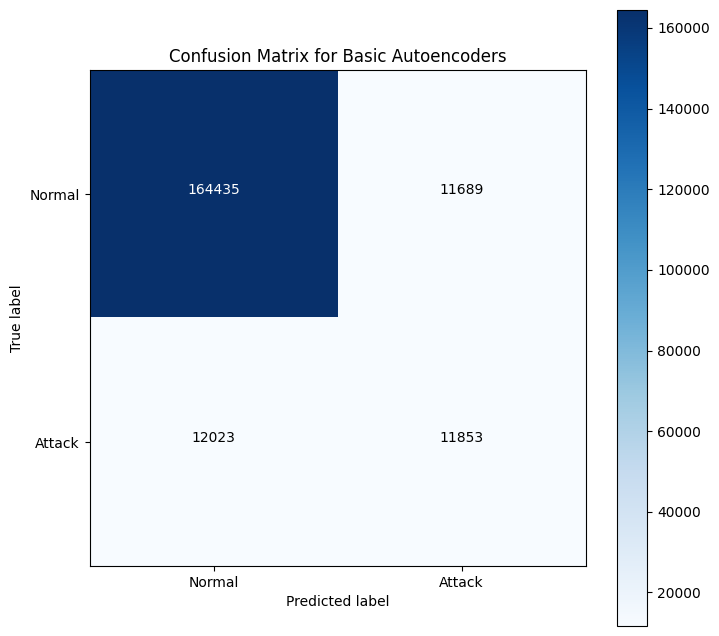

Using Basic Autoencoders:
CIC-IDS Accuracy: 0.8814
CIC-IDS Precision: 0.5035
CIC-IDS Recall: 0.4964
CIC-IDS F1: 0.4999
CIC-IDS Miss Rate: 0.5036
CIC-IDS Training Time: 35.3036
CIC-IDS CPU Usage: 0.1000


In [9]:
from sklearn.metrics import confusion_matrix


y_pred = predictions
y_true = cicids_test.y.to_numpy()


# plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)
print("True Positives:", tp)

def plot_cm(cm):
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, cmap=plt.cm.Blues)
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2. else "black")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    class_names = ['Normal', 'Attack']
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    plt.title("Confusion Matrix for Basic Autoencoders")
    plt.colorbar()
    plt.show()

plot_cm(cm)



cicids_acc = (tn + tp) / (tn + fp + fn + tp)
cicids_prec = tp / (tp + fp)
cicids_rec = tp / (tp + fn)
cicids_f1 = 2 * cicids_prec * cicids_rec / (cicids_prec + cicids_rec)
cicids_miss = fn / (fn + tp)

print("Using Basic Autoencoders:")
print(f"CIC-IDS Accuracy: {cicids_acc:.4f}")
print(f"CIC-IDS Precision: {cicids_prec:.4f}")
print(f"CIC-IDS Recall: {cicids_rec:.4f}")
print(f"CIC-IDS F1: {cicids_f1:.4f}")
print(f"CIC-IDS Miss Rate: {cicids_miss:.4f}")
print(f"CIC-IDS Training Time: {training_time_cicids:.4f}")
print(f"CIC-IDS CPU Usage: {cpu_usage_cicids:.4f}")

In [25]:
'''def create_model(num_features):
    """
    Creates a deep autoencoder to process tabular data with the total number of features represented by num_features.
    """
    model = tf.keras.models.Sequential([
        Input(shape=(num_features,)),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(8, activation='relu'),
        Dense(4, activation='relu'),
        Dense(8, activation='relu'),
        Dense(16, activation='relu'),
        Dense(32, activation='relu'),
        Dense(num_features, activation='sigmoid')
    ])
    model.compile(optimizer="adam", loss="mean_squared_error")
    
    return model'''
from keras import regularizers
from scipy.stats import norm

def create_model(num_features):
    """
    Creates a deep autoencoder to process tabular data with the total number of features represented by num_features.
    """
    model = tf.keras.models.Sequential([
        Input(shape=(num_features,)),
        Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        Dense(num_features, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01))
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss="mean_squared_error")
    
    return model


class AutoencoderClassifier:
    
    def __init__(self, x_train, y_train, x_test, y_test):
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.model = create_model(x_train.shape[1])
        self.threshold = None
    
    def fit(self):
        start = time()
        cpu_usage = psutil.cpu_percent(interval= None)
        history = self.model.fit(
            self.x_train,
            self.x_train,
            batch_size=256,
            shuffle=True,
            epochs=10
        )
        training_time_cicids = time()-start 
        cpu_usage_cicids = cpu_usage
        '''reconstruction_losses = self.calculate_reconstruction_loss(self.x_train)
        count_0 = self.y_train.value_counts()[0]
        count_1 = self.y_train.value_counts()[1]
        self.threshold = np.quantile(reconstruction_losses, count_1/(count_0+count_1))'''
        reconstruction_losses = self.calculate_reconstruction_loss(self.x_train)
        count_0 = self.y_train.value_counts()[0]
        count_1 = self.y_train.value_counts()[1]
        
        # Calculate threshold using α% abnormality
        alpha = count_1 / (count_0 + count_1)
        mean_reconstruction_error = np.mean(reconstruction_losses)
        std_reconstruction_error = np.std(reconstruction_losses)
        z_value = norm.ppf(1 - alpha)
        threshold = mean_reconstruction_error + z_value * std_reconstruction_error
        self.threshold = threshold

        # Plot reconstruction losses with frequency
        plt.figure(figsize=(8, 6))
        plt.hist(reconstruction_losses[self.y_train == 0], bins=50, color='green', alpha=0.5, label='Normal')
        plt.hist(reconstruction_losses[self.y_train == 1], bins=50, color='red', alpha=0.5, label='Abnormal')
        plt.axvline(x=threshold, color='blue', linestyle='--', label='Threshold')
        plt.xlabel('Reconstruction Loss')
        plt.ylabel('Frequency')
        plt.title('Distribution of Reconstruction Losses')
        plt.legend()
        plt.show()

        return training_time_cicids,cpu_usage_cicids
    
    def calculate_reconstruction_loss(self, x):
        reconstructions = self.model.predict(x)
        losses = np.mean(np.abs(x - reconstructions), axis=1)
        return losses
    
    def predict(self):
        test_losses = self.calculate_reconstruction_loss(self.x_test)
        predictions = test_losses > self.threshold
        return predictions
    
    def evaluate(self):
        train_losses = self.calculate_reconstruction_loss(self.x_train)
        train_predictions = train_losses > self.threshold

        test_losses = self.calculate_reconstruction_loss(self.x_test)
        test_predictions = test_losses > self.threshold
        
        metrics = {
            'accuracy': accuracy_score(self.y_test, test_predictions),
            'precision': precision_score(self.y_test, test_predictions),
            'recall': recall_score(self.y_test, test_predictions),
            'f1_score': f1_score(self.y_test, test_predictions),
            'auc': roc_auc_score(self.y_test, test_losses)
        }
        
        return metrics


In [26]:
classifier = AutoencoderClassifier(cicids_train.X, cicids_train.y, cicids_test.X, cicids_test.y)

training_time_cicids,cpu_usage_cicids= classifier.fit()

predictions = classifier.predict()

metrics = classifier.evaluate()

# Print the evaluation metrics
print("Accuracy:", metrics['accuracy'])
print("Precision:", metrics['precision'])
print("Recall:", metrics['recall'])
print("F1 Score:", metrics['f1_score'])
print("AUC:", metrics['auc'])

Epoch 1/10


2023-06-19 18:01:45.154695: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype double and shape [800000,39]
	 [[{{node Placeholder/_11}}]]
2023-06-19 18:01:45.155061: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype double and shape [800000,39]
	 [[{{node Placeholder/_11}}]]


3125/3125 [==============================] - 5s 1ms/step - loss: 0.4916
Epoch 2/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0919
Epoch 3/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0662
Epoch 4/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0529
Epoch 5/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0442
Epoch 6/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0384
Epoch 7/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0344
Epoch 8/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0318
Epoch 9/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0301
Epoch 10/10
  117/25000 [..............................] - ETA: 21s 

2023-06-19 18:02:27.617207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [800000,39]
	 [[{{node Placeholder/_10}}]]
2023-06-19 18:02:27.617500: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [800000,39]
	 [[{{node Placeholder/_10}}]]


25000/25000 [==============================] - 18s 724us/step


 281/6250 [>.............................] - ETA: 3s

2023-06-19 18:02:51.312272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [200000,39]
	 [[{{node Placeholder/_10}}]]
2023-06-19 18:02:51.312553: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [200000,39]
	 [[{{node Placeholder/_10}}]]


  200/25000 [..............................] - ETA: 18s

2023-06-19 18:02:57.008717: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [800000,39]
	 [[{{node Placeholder/_10}}]]
2023-06-19 18:02:57.008989: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [800000,39]
	 [[{{node Placeholder/_10}}]]


 298/6250 [>.............................] - ETA: 3s

2023-06-19 18:03:20.148388: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [200000,39]
	 [[{{node Placeholder/_10}}]]
2023-06-19 18:03:20.148659: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [200000,39]
	 [[{{node Placeholder/_10}}]]


6250/6250 [==============================] - 4s 586us/step
Accuracy: 0.881345
Precision: 0.5030784255445628
Recall: 0.4962305243759424
F1 Score: 0.4996310118708752
AUC: 0.734681551692671


True Negatives: 164421
False Positives: 11703
False Negatives: 12028
True Positives: 11848


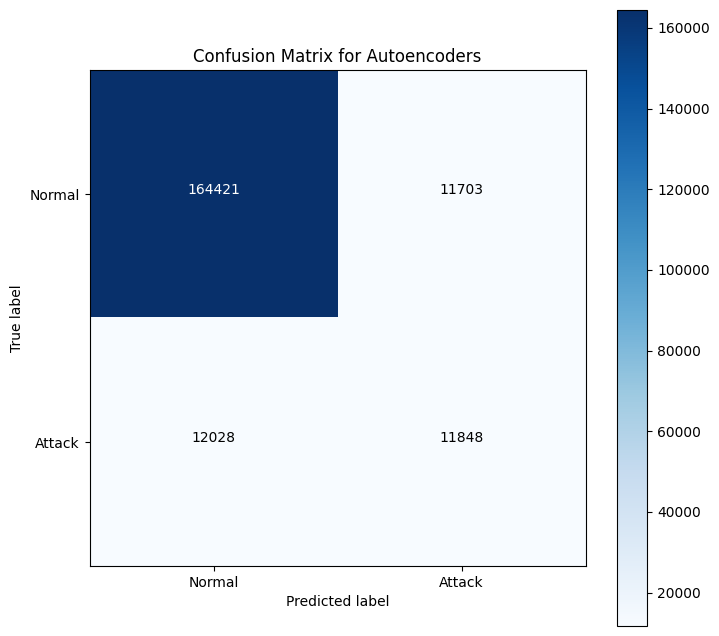

Using Autoencoders:
CIC-IDS Accuracy: 0.8813
CIC-IDS Precision: 0.5031
CIC-IDS Recall: 0.4962
CIC-IDS F1: 0.4996
CIC-IDS Miss Rate: 0.5038
CIC-IDS Training Time: 42.7563
CIC-IDS CPU Usage: 0.5000


In [27]:
from sklearn.metrics import confusion_matrix


y_pred = predictions
y_true = cicids_test.y.to_numpy()


# plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)
print("True Positives:", tp)

def plot_cm(cm):
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, cmap=plt.cm.Blues)
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2. else "black")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    class_names = ['Normal', 'Attack']
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    plt.title("Confusion Matrix for Stacked Autoencoders")
    plt.colorbar()
    plt.show()

plot_cm(cm)



cicids_acc = (tn + tp) / (tn + fp + fn + tp)
cicids_prec = tp / (tp + fp)
cicids_rec = tp / (tp + fn)
cicids_f1 = 2 * cicids_prec * cicids_rec / (cicids_prec + cicids_rec)
cicids_miss = fn / (fn + tp)

print("Using Stacked Autoencoders:")
print(f"CIC-IDS Accuracy: {cicids_acc:.4f}")
print(f"CIC-IDS Precision: {cicids_prec:.4f}")
print(f"CIC-IDS Recall: {cicids_rec:.4f}")
print(f"CIC-IDS F1: {cicids_f1:.4f}")
print(f"CIC-IDS Miss Rate: {cicids_miss:.4f}")
print(f"CIC-IDS Training Time: {training_time_cicids:.4f}")
print(f"CIC-IDS CPU Usage: {cpu_usage_cicids:.4f}")

In [15]:
from keras.layers import GaussianNoise

def create_model(num_features, noise_stddev):
    """
    Creates a denoising autoencoder to process tabular data with the total number of features represented by num_features.
    Applies Gaussian noise with standard deviation noise_stddev to the input data.
    """
    model = tf.keras.models.Sequential([
        Input(shape=(num_features,)),
        GaussianNoise(noise_stddev),
        Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        Dense(num_features, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01))
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss="mean_squared_error")
    
    return model

class DenoisingAutoencoderClassifier:
    
    def __init__(self, x_train, y_train, x_test, y_test, noise_stddev=0.1):
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.model = create_model(x_train.shape[1], noise_stddev)
        self.threshold = None
    
    def fit(self):
        start = time()
        cpu_usage = psutil.cpu_percent(interval= None)
        history = self.model.fit(
            self.x_train,
            self.x_train,
            batch_size=256,
            shuffle=True,
            epochs=10
        )
        training_time_cicids = time()-start 
        cpu_usage_cicids = cpu_usage
        '''reconstruction_losses = self.calculate_reconstruction_loss(self.x_train)
        count_0 = self.y_train.value_counts()[0]
        count_1 = self.y_train.value_counts()[1]
        self.threshold = np.quantile(reconstruction_losses, count_1/(count_0+count_1))'''
        reconstruction_losses = self.calculate_reconstruction_loss(self.x_train)
        count_0 = self.y_train.value_counts()[0]
        count_1 = self.y_train.value_counts()[1]
        
        # Calculate threshold using α% abnormality
        alpha = count_1 / (count_0 + count_1)
        mean_reconstruction_error = np.mean(reconstruction_losses)
        std_reconstruction_error = np.std(reconstruction_losses)
        z_value = norm.ppf(1 - alpha)
        threshold = mean_reconstruction_error + z_value * std_reconstruction_error
        self.threshold = threshold

        # Plot reconstruction losses with frequency
        plt.figure(figsize=(8, 6))
        plt.hist(reconstruction_losses[self.y_train == 0], bins=50, color='green', alpha=0.5, label='Normal')
        plt.hist(reconstruction_losses[self.y_train == 1], bins=50, color='red', alpha=0.5, label='Abnormal')
        plt.axvline(x=threshold, color='blue', linestyle='--', label='Threshold')
        plt.xlabel('Reconstruction Loss')
        plt.ylabel('Frequency')
        plt.title('Distribution of Reconstruction Losses')
        plt.legend()
        plt.show()

        return training_time_cicids,cpu_usage_cicids
    
    def calculate_reconstruction_loss(self, x):
        reconstructions = self.model.predict(x)
        losses = np.mean(np.abs(x - reconstructions), axis=1)
        return losses
    
    def predict(self):
        test_losses = self.calculate_reconstruction_loss(self.x_test)
        predictions = test_losses > self.threshold
        return predictions
    
    def evaluate(self):
        train_losses = self.calculate_reconstruction_loss(self.x_train)
        train_predictions = train_losses > self.threshold

        test_losses = self.calculate_reconstruction_loss(self.x_test)
        test_predictions = test_losses > self.threshold
        
        metrics = {
            'accuracy': accuracy_score(self.y_test, test_predictions),
            'precision': precision_score(self.y_test, test_predictions),
            'recall': recall_score(self.y_test, test_predictions),
            'f1_score': f1_score(self.y_test, test_predictions),
            'auc': roc_auc_score(self.y_test, test_losses)
        }
        
        return metrics

Epoch 1/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.3679
Epoch 2/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.1056
Epoch 3/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0730
Epoch 4/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0552
Epoch 5/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0446
Epoch 6/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0382
Epoch 7/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0341
Epoch 8/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0315
Epoch 9/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0299
Epoch 10/10
25000/25000 [==============================] - 15s 607us/step


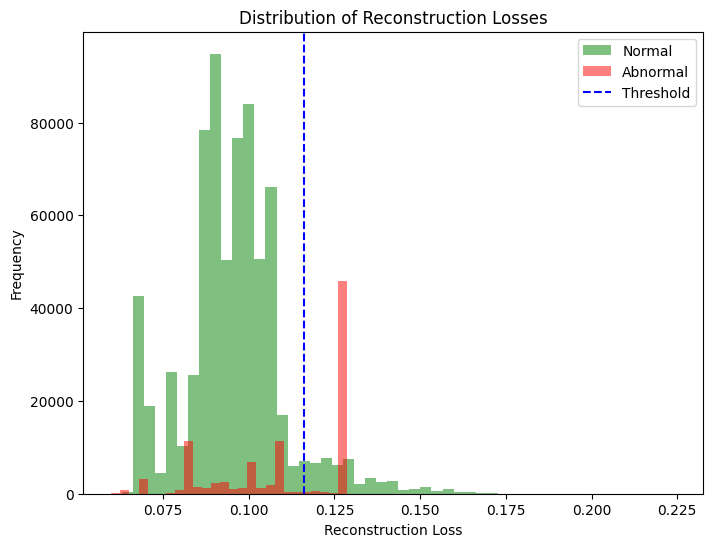

6250/6250 [==============================] - 3s 544us/step
Accuracy: 0.88132
Precision: 0.5029711375212224
Recall: 0.4963142905009214
F1 Score: 0.4996205413609916
AUC: 0.7347165267750881


In [16]:
classifier = DenoisingAutoencoderClassifier(cicids_train.X, cicids_train.y, cicids_test.X, cicids_test.y)

training_time_cicids,cpu_usage_cicids= classifier.fit()

predictions = classifier.predict()

metrics = classifier.evaluate()

# Print the evaluation metrics
print("Accuracy:", metrics['accuracy'])
print("Precision:", metrics['precision'])
print("Recall:", metrics['recall'])
print("F1 Score:", metrics['f1_score'])
print("AUC:", metrics['auc'])

True Negatives: 164414
False Positives: 11710
False Negatives: 12026
True Positives: 11850


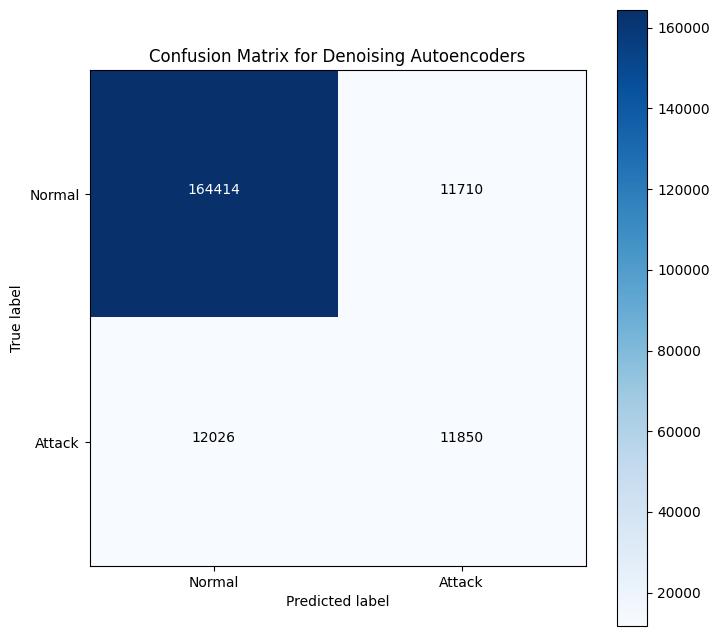

Using Denoising Autoencoders:
CIC-IDS Accuracy: 0.8813
CIC-IDS Precision: 0.5030
CIC-IDS Recall: 0.4963
CIC-IDS F1: 0.4996
CIC-IDS Miss Rate: 0.5037
CIC-IDS Training Time: 37.0728
CIC-IDS CPU Usage: 0.1000


In [17]:
from sklearn.metrics import confusion_matrix


y_pred = predictions
y_true = cicids_test.y.to_numpy()


# plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)
print("True Positives:", tp)

def plot_cm(cm):
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, cmap=plt.cm.Blues)
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2. else "black")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    class_names = ['Normal', 'Attack']
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    plt.title("Confusion Matrix for Denoising Autoencoders")
    plt.colorbar()
    plt.show()

plot_cm(cm)



cicids_acc = (tn + tp) / (tn + fp + fn + tp)
cicids_prec = tp / (tp + fp)
cicids_rec = tp / (tp + fn)
cicids_f1 = 2 * cicids_prec * cicids_rec / (cicids_prec + cicids_rec)
cicids_miss = fn / (fn + tp)

print("Using Denoising Autoencoders:")
print(f"CIC-IDS Accuracy: {cicids_acc:.4f}")
print(f"CIC-IDS Precision: {cicids_prec:.4f}")
print(f"CIC-IDS Recall: {cicids_rec:.4f}")
print(f"CIC-IDS F1: {cicids_f1:.4f}")
print(f"CIC-IDS Miss Rate: {cicids_miss:.4f}")
print(f"CIC-IDS Training Time: {training_time_cicids:.4f}")
print(f"CIC-IDS CPU Usage: {cpu_usage_cicids:.4f}")

25000/25000 [==============================] - 19s 766us/step


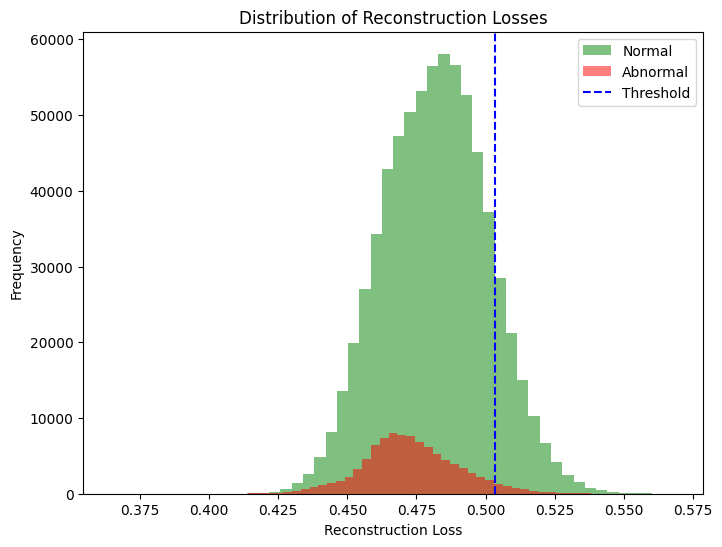

6250/6250 [==============================] - 4s 590us/step
Accuracy: 0.772675
Precision: 0.050135444884350906
Recall: 0.05038532417490367
F1 Score: 0.05026007394873723


In [5]:
from keras import backend as K
from keras.layers import Lambda
from keras.losses import mean_squared_error


def create_model(num_features):
    """
    Creates a variational autoencoder model to process tabular data with the total number of features represented by num_features.
    """
    # Encoder
    inputs = Input(shape=(num_features,))
    x = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01))(inputs)
    x = Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    z_mean = Dense(8, name='z_mean')(x)
    z_log_var = Dense(8, name='z_log_var')(x)
    
    # Sampling
    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], 8), mean=0., stddev=1.)
        return z_mean + K.exp(0.5 * z_log_var) * epsilon
    
    z = Lambda(sampling, output_shape=(8,), name='z')([z_mean, z_log_var])
    
    # Decoder
    decoder_inputs = Input(shape=(8,))
    x = Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01))(decoder_inputs)
    x = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    outputs = Dense(num_features, activation='sigmoid')(x)
    
    # Models
    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
    decoder = Model(decoder_inputs, outputs, name='decoder')
    autoencoder = Model(inputs, decoder(encoder(inputs)[2]), name='autoencoder')
    
    # Loss function
    def vae_loss(inputs, outputs):
        reconstruction_loss = mean_squared_error(inputs, outputs)
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(reconstruction_loss + kl_loss)
    
    # Compile the autoencoder model
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    autoencoder.compile(optimizer=optimizer, loss=vae_loss)
    
    return autoencoder



'''@tf.function
def train_step(model, inputs, optimizer):
    inputs = tf.cast(inputs, dtype=tf.float32)
    with tf.GradientTape() as tape:
        reconstructions = model(inputs)
        reconstructions = tf.cast(reconstructions, dtype=tf.float32)
        loss = tf.reduce_mean(tf.square(inputs - reconstructions))
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss'''



def train_step(model, inputs, optimizer):
    inputs = tf.cast(inputs, dtype=tf.float32)
    with tf.GradientTape() as tape:
        reconstructions = model(inputs)
        reconstructions = tf.cast(reconstructions, dtype=tf.float32)
        loss = tf.reduce_mean(tf.square(inputs - reconstructions))
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss




class VariationalAutoencoderClassifier:
    def __init__(self, x_train, y_train, x_test, y_test):
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.model = create_model(x_train.shape[1])
        self.threshold = None
    
    def fit(self):
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
        start = time()
        cpu_usage = psutil.cpu_percent(interval=None)
        history = []
        for epoch in range(10):
            loss = train_step(self.model, self.x_train, optimizer)
            history.append(loss)
        training_time_cicids = time() - start 
        cpu_usage_cicids = cpu_usage
        
        reconstruction_losses = self.calculate_reconstruction_loss(self.x_train)
        count_0 = self.y_train.value_counts()[0]
        count_1 = self.y_train.value_counts()[1]
        
        # Calculate threshold using α% abnormality
        alpha = count_1 / (count_0 + count_1)
        mean_reconstruction_error = np.mean(reconstruction_losses)
        std_reconstruction_error = np.std(reconstruction_losses)
        z_value = norm.ppf(1 - alpha)
        threshold = mean_reconstruction_error + z_value * std_reconstruction_error
        self.threshold = threshold

        # Plot reconstruction losses with frequency
        plt.figure(figsize=(8, 6))
        plt.hist(reconstruction_losses[self.y_train == 0], bins=50, color='green', alpha=0.5, label='Normal')
        plt.hist(reconstruction_losses[self.y_train == 1], bins=50, color='red', alpha=0.5, label='Abnormal')
        plt.axvline(x=threshold, color='blue', linestyle='--', label='Threshold')
        plt.xlabel('Reconstruction Loss')
        plt.ylabel('Frequency')
        plt.title('Distribution of Reconstruction Losses')
        plt.legend()
        plt.show()

        return training_time_cicids, cpu_usage_cicids
    
    def calculate_reconstruction_loss(self, x):
        reconstructions = self.model.predict(x)
        losses = np.mean(np.abs(x - reconstructions), axis=1)
        return losses
    
    def predict(self):
        test_losses = self.calculate_reconstruction_loss(self.x_test)
        predictions = test_losses > self.threshold
        return predictions
    
    def evaluate(self):
        train_losses = self.calculate_reconstruction_loss(self.x_train)
        train_predictions = train_losses > self.threshold

        test_losses = self.calculate_reconstruction_loss(self.x_test)
        test_predictions = test_losses > self.threshold
        
        metrics = {
            'accuracy': accuracy_score(self.y_test, test_predictions),
            'precision': precision_score(self.y_test, test_predictions),
            'recall': recall_score(self.y_test, test_predictions),
            'f1_score': f1_score(self.y_test, test_predictions),
            'auc': roc_auc_score(self.y_test, test_losses)
        }
        
        return metrics


classifier = VariationalAutoencoderClassifier(cicids_train.X, cicids_train.y, cicids_test.X, cicids_test.y)

training_time_cicids, cpu_usage_cicids = classifier.fit()
predictions = classifier.predict()
metrics = classifier.evaluate()

# Print the evaluation metrics
print("Accuracy:", metrics['accuracy'])
print("Precision:", metrics['precision'])
print("Recall:", metrics['recall'])
print("F1 Score:", metrics['f1_score'])

True Negatives: 153194
False Positives: 22930
False Negatives: 22697
True Positives: 1179


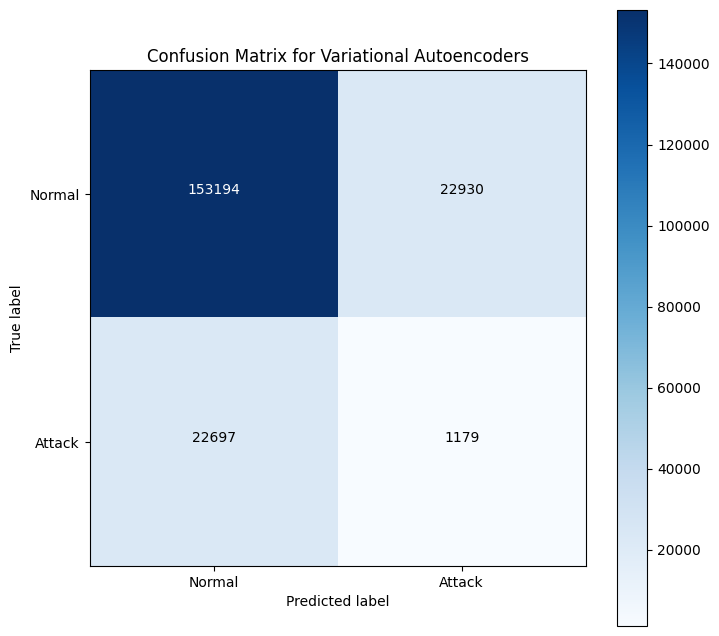

Using Variational Autoencoders:
CIC-IDS Accuracy: 0.7719
CIC-IDS Precision: 0.0489
CIC-IDS Recall: 0.0494
CIC-IDS F1: 0.0491
CIC-IDS Miss Rate: 0.9506
CIC-IDS Training Time: 8.8236
CIC-IDS CPU Usage: 0.3000


In [6]:
from sklearn.metrics import confusion_matrix


y_pred = predictions
y_true = cicids_test.y.to_numpy()


# plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)
print("True Positives:", tp)

def plot_cm(cm):
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, cmap=plt.cm.Blues)
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2. else "black")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    class_names = ['Normal', 'Attack']
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    plt.title("Confusion Matrix for Variational Autoencoders")
    plt.colorbar()
    plt.show()

plot_cm(cm)



cicids_acc = (tn + tp) / (tn + fp + fn + tp)
cicids_prec = tp / (tp + fp)
cicids_rec = tp / (tp + fn)
cicids_f1 = 2 * cicids_prec * cicids_rec / (cicids_prec + cicids_rec)
cicids_miss = fn / (fn + tp)

print("Using Variational Autoencoders:")
print(f"CIC-IDS Accuracy: {cicids_acc:.4f}")
print(f"CIC-IDS Precision: {cicids_prec:.4f}")
print(f"CIC-IDS Recall: {cicids_rec:.4f}")
print(f"CIC-IDS F1: {cicids_f1:.4f}")
print(f"CIC-IDS Miss Rate: {cicids_miss:.4f}")
print(f"CIC-IDS Training Time: {training_time_cicids:.4f}")
print(f"CIC-IDS CPU Usage: {cpu_usage_cicids:.4f}")

# On other Datasets

In [10]:
botiot: Tuple[Dataset, Dataset] = load_data("data/sampled/botiot_sampled.csv.gz", seed=SEED, n_partition=1, only_benign=False) # type: ignore
nb15: Tuple[Dataset, Dataset] = load_data("data/sampled/nb15_sampled.csv.gz", seed=SEED, n_partition=1, only_benign=False) # type: ignore
toniot: Tuple[Dataset, Dataset] = load_data("data/sampled/toniot_sampled.csv.gz", seed=SEED, n_partition=1, only_benign=False) # type: ignore

Epoch 1/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.3630
Epoch 2/10
3125/3125 [==============================] - 3s 1ms/step - loss: 0.1085
Epoch 3/10
3125/3125 [==============================] - 3s 1ms/step - loss: 0.0752
Epoch 4/10
3125/3125 [==============================] - 3s 1ms/step - loss: 0.0566
Epoch 5/10
3125/3125 [==============================] - 3s 1ms/step - loss: 0.0455
Epoch 6/10
3125/3125 [==============================] - 3s 1ms/step - loss: 0.0387
Epoch 7/10
3125/3125 [==============================] - 3s 1ms/step - loss: 0.0345
Epoch 8/10
3125/3125 [==============================] - 3s 1ms/step - loss: 0.0318
Epoch 9/10
3125/3125 [==============================] - 3s 1ms/step - loss: 0.0300
Epoch 10/10
25000/25000 [==============================] - 14s 556us/step


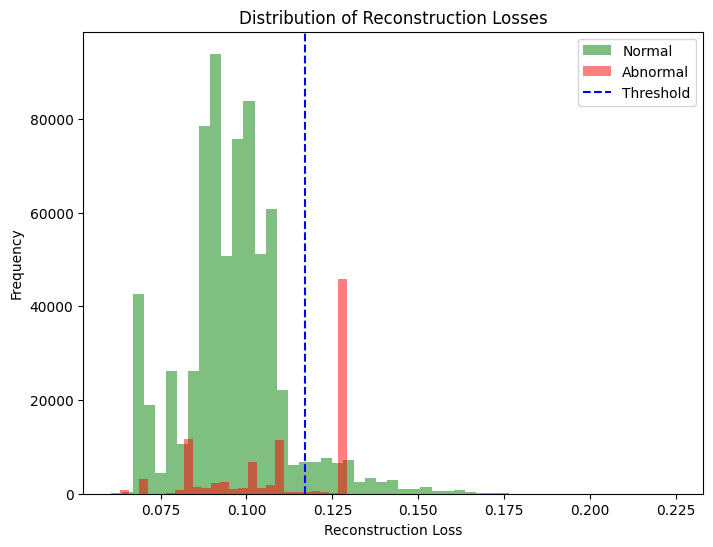

6250/6250 [==============================] - 3s 529us/step
Epoch 1/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.3512
Epoch 2/10
3125/3125 [==============================] - 3s 1ms/step - loss: 0.0979
Epoch 3/10
3125/3125 [==============================] - 3s 1ms/step - loss: 0.0717
Epoch 4/10
3125/3125 [==============================] - 3s 1ms/step - loss: 0.0565
Epoch 5/10
3125/3125 [==============================] - 3s 1ms/step - loss: 0.0470
Epoch 6/10
3125/3125 [==============================] - 3s 1ms/step - loss: 0.0412
Epoch 7/10
3125/3125 [==============================] - 3s 1ms/step - loss: 0.0375
Epoch 8/10
3125/3125 [==============================] - 3s 1ms/step - loss: 0.0352
Epoch 9/10
3125/3125 [==============================] - 3s 1ms/step - loss: 0.0337
Epoch 10/10
25000/25000 [==============================] - 16s 625us/step


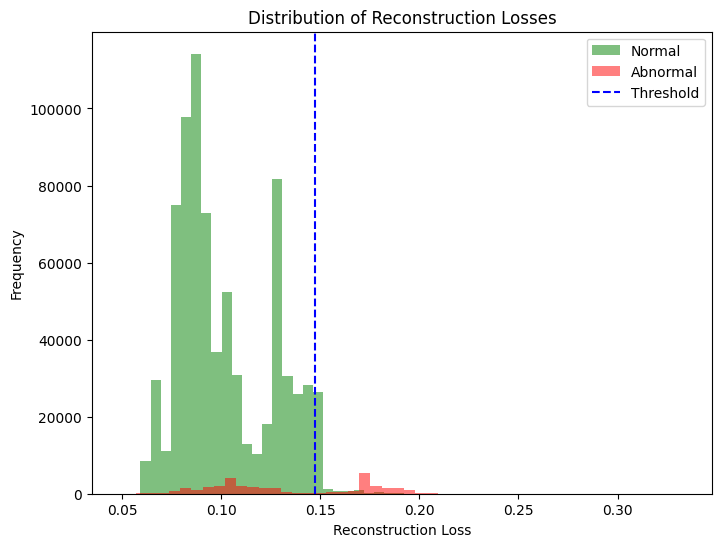

6250/6250 [==============================] - 3s 536us/step
Epoch 1/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.3790
Epoch 2/10
3125/3125 [==============================] - 3s 1ms/step - loss: 0.1060
Epoch 3/10
3125/3125 [==============================] - 3s 1ms/step - loss: 0.0660
Epoch 4/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0444
Epoch 5/10
3125/3125 [==============================] - 3s 1ms/step - loss: 0.0315
Epoch 6/10
3125/3125 [==============================] - 3s 1ms/step - loss: 0.0236
Epoch 7/10
3125/3125 [==============================] - 3s 1ms/step - loss: 0.0187
Epoch 8/10
3125/3125 [==============================] - 3s 1ms/step - loss: 0.0156
Epoch 9/10
3125/3125 [==============================] - 3s 1ms/step - loss: 0.0136
Epoch 10/10
25000/25000 [==============================] - 16s 618us/step


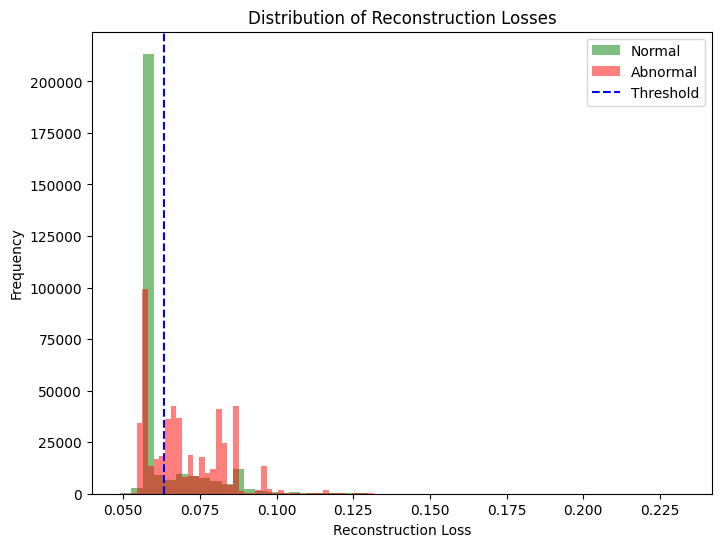

6250/6250 [==============================] - 3s 490us/step
Epoch 1/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.3564
Epoch 2/10
3125/3125 [==============================] - 3s 1ms/step - loss: 0.0879
Epoch 3/10
3125/3125 [==============================] - 3s 1ms/step - loss: 0.0584
Epoch 4/10
3125/3125 [==============================] - 3s 1ms/step - loss: 0.0412
Epoch 5/10
3125/3125 [==============================] - 3s 1ms/step - loss: 0.0305
Epoch 6/10
3125/3125 [==============================] - 3s 1ms/step - loss: 0.0239
Epoch 7/10
3125/3125 [==============================] - 3s 1ms/step - loss: 0.0197
Epoch 8/10
3125/3125 [==============================] - 3s 1ms/step - loss: 0.0170
Epoch 9/10
3125/3125 [==============================] - 3s 1ms/step - loss: 0.0152
Epoch 10/10
25000/25000 [==============================] - 16s 622us/step


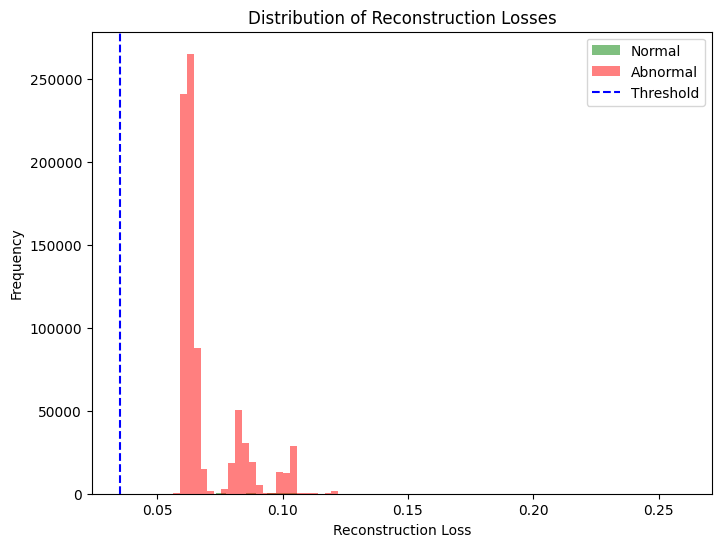

6250/6250 [==============================] - 3s 433us/step


In [11]:


def eval_on_BAE(train, test):
    model = BasicAutoencoderClassifier(train.X, train.y, test.X, test.y)
    start = time()
    cpu_usage = psutil.cpu_percent(interval= None)
    model.fit()
    training_time_ = time()-start 
    y_pred = model.predict()
    y_true = test.y.to_numpy()
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    acc = (tn + tp) / (tn + fp + fn + tp)
    prec = tp / (tp + fp)
    rec = tp / (tp + fn) 
    f1 = 2 * prec * rec / (prec + rec)
    miss = fn / (fn + tp)
    return {
        "tp": tp,
        "tn": tn,
        "fp": fp,
        "fn": fn,
        "acc": acc,
        "prec": prec,
        "rec": rec,
        "f1": f1,
        "miss": miss,
        "training time":training_time_,
        "cpu usage":cpu_usage
    }, model


cicids_BAEresults, cicids_BAE = eval_on_BAE(*cicids)
nb15_BAEresults, nb15_BAE = eval_on_BAE(*nb15)
toniot_BAEresults, toniot_BAE = eval_on_BAE(*toniot)
botiot_BAEresults, botiot_BAE = eval_on_BAE(*botiot)




In [12]:
df_results_BAE = pd.DataFrame(columns=["Dataset", "Accuracy", "Precision", "Recall", "F1", "Miss Rate", "Training Time", "CPU Usage"])

dfs = []
for dataset_BAE in [
    ("CIC-IDS", cicids_BAEresults),
    ("UNSW-NB15", nb15_BAEresults),
    ("ToN-IoT", toniot_BAEresults),
    ("Bot-IoT", botiot_BAEresults),
]:
    data = {
        "Dataset": [dataset_BAE[0]],
        "Accuracy": [dataset_BAE[1]["acc"]],
        "Precision": [dataset_BAE[1]["prec"]],
        "Recall": [dataset_BAE[1]["rec"]],
        "F1": [dataset_BAE[1]["f1"]],
        "Miss Rate": [dataset_BAE[1]["miss"]],
        "Training Time": [dataset_BAE[1]["training time"]],
        "CPU Usage": [dataset_BAE[1]["cpu usage"]]
    }
    df = pd.DataFrame(data)
    dfs.append(df)

df_results_BAE = pd.concat(dfs, ignore_index=True)
print("-------------Using Basic Autoencoders----------------")
df_results_BAE

-------------Using Basic Autoencoders----------------


Dataset  Accuracy  Precision    Recall        F1  Miss Rate  \
0    CIC-IDS  0.881320   0.502971  0.496272  0.499599   0.503728   
1  UNSW-NB15  0.944415   0.336192  0.402680  0.366444   0.597320   
2    ToN-IoT  0.695190   0.839042  0.648404  0.731506   0.351596   
3    Bot-IoT  0.996430   0.996430  1.000000  0.998212   0.000000   

   Training Time  CPU Usage  
0      55.430579        0.7  
1      57.518859        0.9  
2      56.933822        0.9  
3      57.394992        0.9

Epoch 1/10


2023-06-19 18:03:38.080937: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [800000,39]
	 [[{{node Placeholder/_10}}]]
2023-06-19 18:03:38.081307: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype double and shape [800000,39]
	 [[{{node Placeholder/_11}}]]


3125/3125 [==============================] - 5s 1ms/step - loss: 0.4866
Epoch 2/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0908
Epoch 3/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0647
Epoch 4/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0512
Epoch 5/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0426
Epoch 6/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0370
Epoch 7/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0335
Epoch 8/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0312
Epoch 9/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0297
Epoch 10/10
  123/25000 [..............................] - ETA: 20s 

2023-06-19 18:04:20.298670: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [800000,39]
	 [[{{node Placeholder/_10}}]]
2023-06-19 18:04:20.298978: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [800000,39]
	 [[{{node Placeholder/_10}}]]


25000/25000 [==============================] - 18s 699us/step


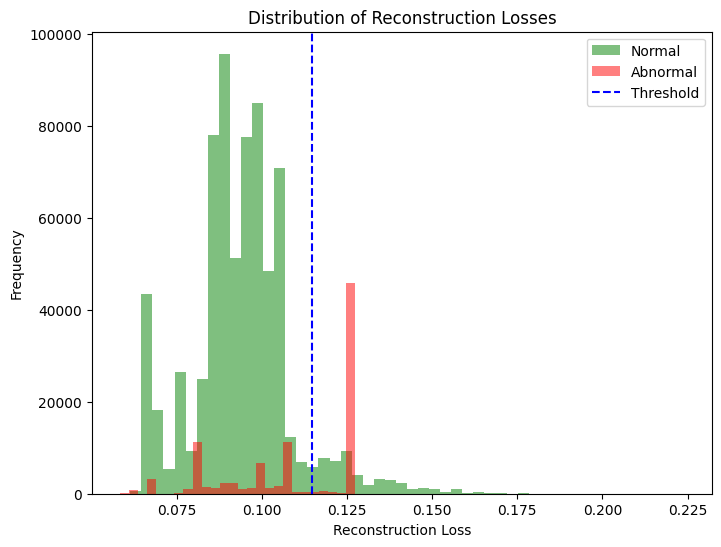

 189/6250 [..............................] - ETA: 4s

2023-06-19 18:04:43.316305: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [200000,39]
	 [[{{node Placeholder/_10}}]]
2023-06-19 18:04:43.316580: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [200000,39]
	 [[{{node Placeholder/_10}}]]


6250/6250 [==============================] - 4s 683us/step
Epoch 1/10


2023-06-19 18:04:49.579822: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype double and shape [800000,39]
	 [[{{node Placeholder/_11}}]]
2023-06-19 18:04:49.580186: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype double and shape [800000,39]
	 [[{{node Placeholder/_11}}]]


3125/3125 [==============================] - 5s 1ms/step - loss: 0.4804
Epoch 2/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0917
Epoch 3/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0664
Epoch 4/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0535
Epoch 5/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0455
Epoch 6/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0404
Epoch 7/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0371
Epoch 8/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0350
Epoch 9/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0336
Epoch 10/10
  118/25000 [..............................] - ETA: 21s 

2023-06-19 18:05:31.359778: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [800000,39]
	 [[{{node Placeholder/_10}}]]
2023-06-19 18:05:31.360044: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [800000,39]
	 [[{{node Placeholder/_10}}]]


25000/25000 [==============================] - 17s 684us/step


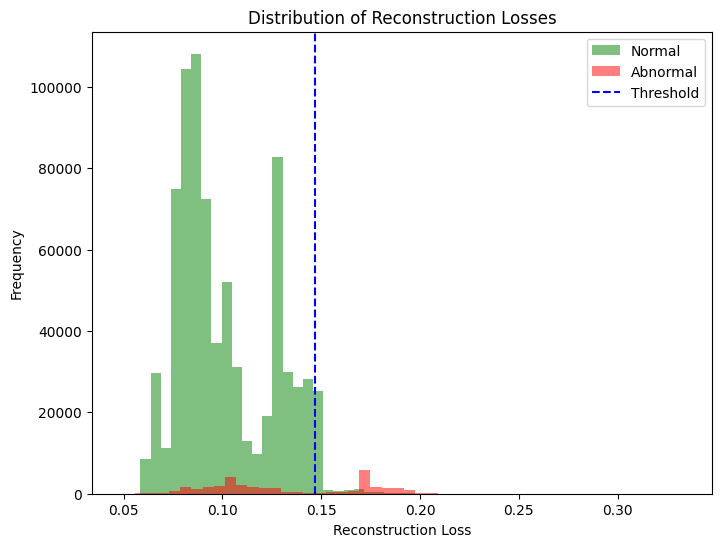

 188/6250 [..............................] - ETA: 4s

2023-06-19 18:05:54.021999: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [200000,39]
	 [[{{node Placeholder/_10}}]]
2023-06-19 18:05:54.022284: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [200000,39]
	 [[{{node Placeholder/_10}}]]


6250/6250 [==============================] - 4s 704us/step
Epoch 1/10


2023-06-19 18:06:00.355573: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype double and shape [800000,39]
	 [[{{node Placeholder/_11}}]]
2023-06-19 18:06:00.355887: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype double and shape [800000,39]
	 [[{{node Placeholder/_11}}]]


3125/3125 [==============================] - 5s 1ms/step - loss: 0.4847
Epoch 2/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0796
Epoch 3/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0509
Epoch 4/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0364
Epoch 5/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0270
Epoch 6/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0210
Epoch 7/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0172
Epoch 8/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0147
Epoch 9/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0131
Epoch 10/10
  122/25000 [..............................] - ETA: 20s 

2023-06-19 18:06:42.679415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [800000,39]
	 [[{{node Placeholder/_10}}]]
2023-06-19 18:06:42.679728: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [800000,39]
	 [[{{node Placeholder/_10}}]]


25000/25000 [==============================] - 17s 675us/step


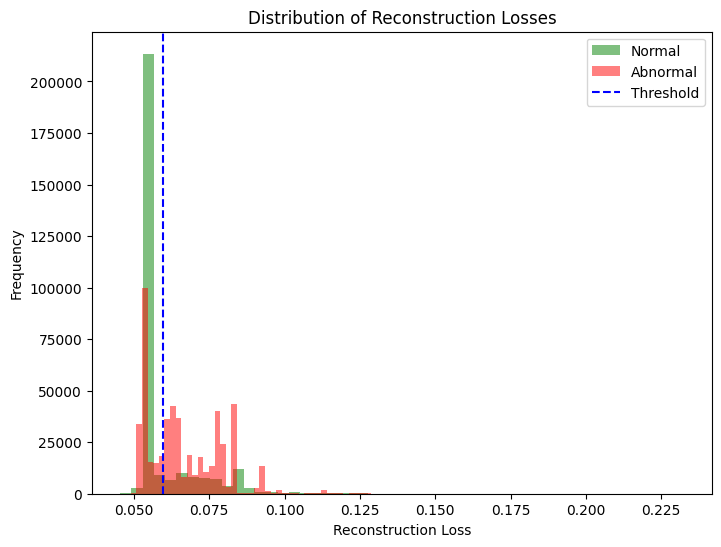

 272/6250 [>.............................] - ETA: 3s

2023-06-19 18:07:05.094848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [200000,39]
	 [[{{node Placeholder/_10}}]]
2023-06-19 18:07:05.095124: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [200000,39]
	 [[{{node Placeholder/_10}}]]


6250/6250 [==============================] - 4s 614us/step
Epoch 1/10


2023-06-19 18:07:10.809340: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype double and shape [800000,39]
	 [[{{node Placeholder/_11}}]]
2023-06-19 18:07:10.809657: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype double and shape [800000,39]
	 [[{{node Placeholder/_11}}]]


3125/3125 [==============================] - 5s 1ms/step - loss: 0.4722
Epoch 2/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0810
Epoch 3/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0540
Epoch 4/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0398
Epoch 5/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0304
Epoch 6/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0242
Epoch 7/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0200
Epoch 8/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0173
Epoch 9/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0154
Epoch 10/10
  133/25000 [..............................] - ETA: 18s 

2023-06-19 18:07:53.112746: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [800000,39]
	 [[{{node Placeholder/_10}}]]
2023-06-19 18:07:53.113026: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [800000,39]
	 [[{{node Placeholder/_10}}]]


25000/25000 [==============================] - 18s 722us/step


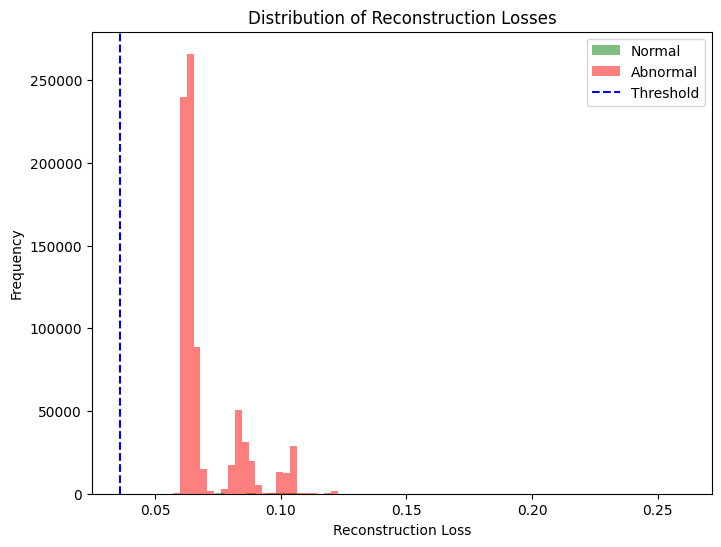

 199/6250 [..............................] - ETA: 4s

2023-06-19 18:08:16.642463: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [200000,39]
	 [[{{node Placeholder/_10}}]]
2023-06-19 18:08:16.642742: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [200000,39]
	 [[{{node Placeholder/_10}}]]


6250/6250 [==============================] - 4s 622us/step


In [28]:


def eval_on_AE(train, test):
    model = AutoencoderClassifier(train.X, train.y, test.X, test.y)
    start = time()
    cpu_usage = psutil.cpu_percent(interval= None)
    model.fit()
    training_time_ = time()-start 
    y_pred = model.predict()
    y_true = test.y.to_numpy()
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    acc = (tn + tp) / (tn + fp + fn + tp)
    prec = tp / (tp + fp)
    rec = tp / (tp + fn) 
    f1 = 2 * prec * rec / (prec + rec)
    miss = fn / (fn + tp)
    return {
        "tp": tp,
        "tn": tn,
        "fp": fp,
        "fn": fn,
        "acc": acc,
        "prec": prec,
        "rec": rec,
        "f1": f1,
        "miss": miss,
        "training time":training_time_,
        "cpu usage":cpu_usage
    }, model


cicids_AEresults, cicids_AE = eval_on_AE(*cicids)
nb15_AEresults, nb15_AE = eval_on_AE(*nb15)
toniot_AEresults, toniot_AE = eval_on_AE(*toniot)
botiot_AEresults, botiot_AE = eval_on_AE(*botiot)




In [30]:
df_results_AE = pd.DataFrame(columns=["Dataset", "Accuracy", "Precision", "Recall", "F1", "Miss Rate", "Training Time", "CPU Usage"])

dfs = []
for dataset_AE in [
    ("CIC-IDS", cicids_AEresults),
    ("UNSW-NB15", nb15_AEresults),
    ("ToN-IoT", toniot_AEresults),
    ("Bot-IoT", botiot_AEresults),
]:
    data = {
        "Dataset": [dataset_AE[0]],
        "Accuracy": [dataset_AE[1]["acc"]],
        "Precision": [dataset_AE[1]["prec"]],
        "Recall": [dataset_AE[1]["rec"]],
        "F1": [dataset_AE[1]["f1"]],
        "Miss Rate": [dataset_AE[1]["miss"]],
        "Training Time": [dataset_AE[1]["training time"]],
        "CPU Usage": [dataset_AE[1]["cpu usage"]]
    }
    df = pd.DataFrame(data)
    dfs.append(df)

df_results_AE = pd.concat(dfs, ignore_index=True)
print("-------------Using Autoencoders----------------")
df_results_AE

-------------Using Autoencoders----------------


Dataset  Accuracy  Precision    Recall        F1  Miss Rate  \
0    CIC-IDS  0.881460   0.503569  0.496440  0.499979   0.503560   
1  UNSW-NB15  0.944645   0.337817  0.402680  0.367408   0.597320   
2    ToN-IoT  0.696075   0.838919  0.650255  0.732636   0.349745   
3    Bot-IoT  0.996430   0.996430  1.000000  0.998212   0.000000   

   Training Time  CPU Usage  
0      65.729373        0.9  
1      64.992895        0.9  
2      65.215383        0.9  
3      66.257172        0.9

Epoch 1/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.3606
Epoch 2/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.1002
Epoch 3/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0694
Epoch 4/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0528
Epoch 5/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0431
Epoch 6/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0372
Epoch 7/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0335
Epoch 8/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0312
Epoch 9/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0297
Epoch 10/10
25000/25000 [==============================] - 16s 631us/step


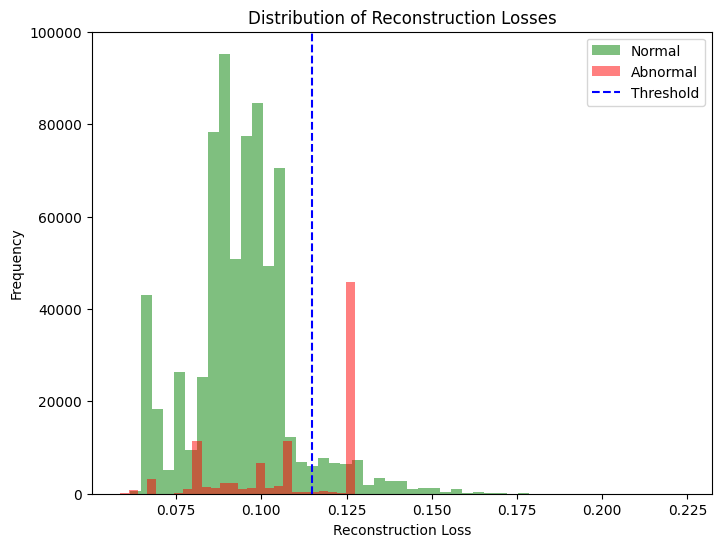

6250/6250 [==============================] - 3s 482us/step
Epoch 1/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.3523
Epoch 2/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0955
Epoch 3/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0701
Epoch 4/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0555
Epoch 5/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0465
Epoch 6/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0409
Epoch 7/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0373
Epoch 8/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0351
Epoch 9/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0337
Epoch 10/10
25000/25000 [==============================] - 15s 583us/step


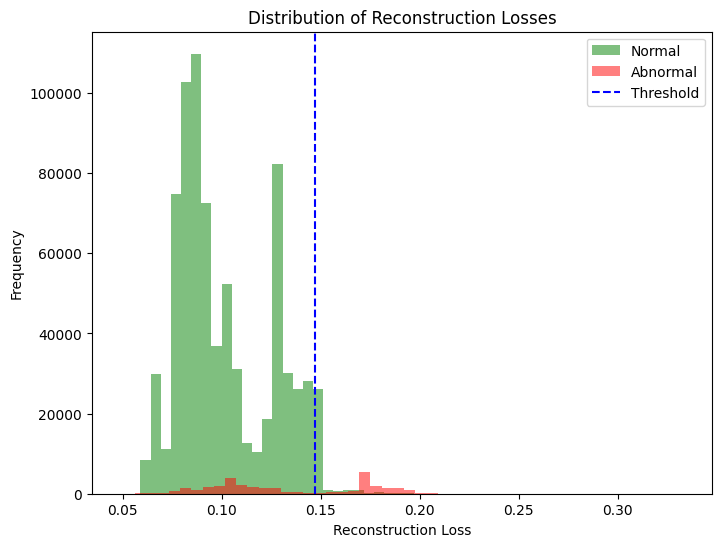

6250/6250 [==============================] - 4s 661us/step
Epoch 1/10
3125/3125 [==============================] - 3s 923us/step - loss: 0.3653
Epoch 2/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0914
Epoch 3/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0561
Epoch 4/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0379
Epoch 5/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0273
Epoch 6/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0210
Epoch 7/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0171
Epoch 8/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0146
Epoch 9/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0130
Epoch 10/10
25000/25000 [==============================] - 16s 637us/step


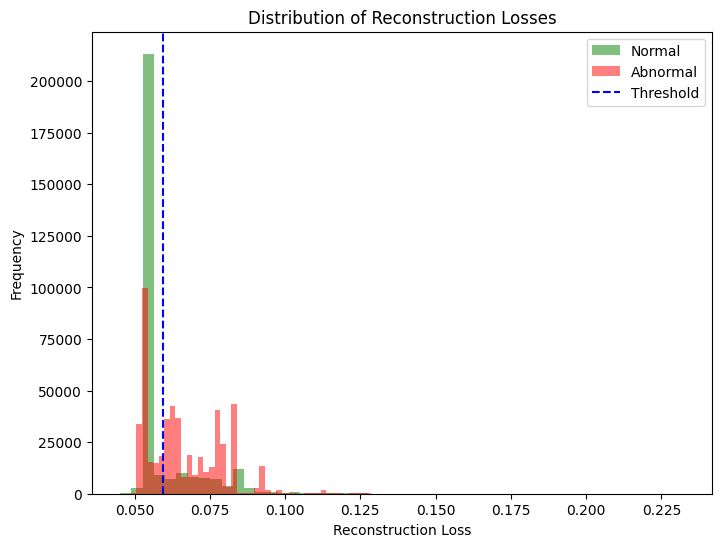

6250/6250 [==============================] - 3s 473us/step
Epoch 1/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.3411
Epoch 2/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0844
Epoch 3/10
3125/3125 [==============================] - 3s 1ms/step - loss: 0.0557
Epoch 4/10
3125/3125 [==============================] - 3s 1ms/step - loss: 0.0392
Epoch 5/10
3125/3125 [==============================] - 3s 1ms/step - loss: 0.0292
Epoch 6/10
3125/3125 [==============================] - 3s 888us/step - loss: 0.0231
Epoch 7/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0192
Epoch 8/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0166
Epoch 9/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.0150
Epoch 10/10
25000/25000 [==============================] - 16s 618us/step


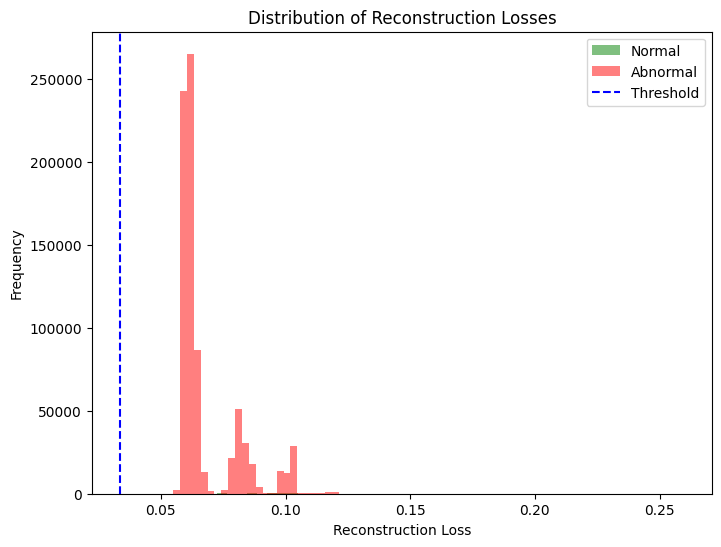

6250/6250 [==============================] - 4s 554us/step


In [18]:


def eval_on_DAE(train, test):
    model = DenoisingAutoencoderClassifier(train.X, train.y, test.X, test.y)
    start = time()
    cpu_usage = psutil.cpu_percent(interval= None)
    model.fit()
    training_time_ = time()-start 
    y_pred = model.predict()
    y_true = test.y.to_numpy()
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    acc = (tn + tp) / (tn + fp + fn + tp)
    prec = tp / (tp + fp)
    rec = tp / (tp + fn) 
    f1 = 2 * prec * rec / (prec + rec)
    miss = fn / (fn + tp)
    return {
        "tp": tp,
        "tn": tn,
        "fp": fp,
        "fn": fn,
        "acc": acc,
        "prec": prec,
        "rec": rec,
        "f1": f1,
        "miss": miss,
        "training time":training_time_,
        "cpu usage":cpu_usage
    }, model


cicids_DAEresults, cicids_DAE = eval_on_DAE(*cicids)
nb15_DAEresults, nb15_DAE = eval_on_DAE(*nb15)
toniot_DAEresults, toniot_DAE = eval_on_DAE(*toniot)
botiot_DAEresults, botiot_DAE = eval_on_DAE(*botiot)




In [20]:
df_results_DAE = pd.DataFrame(columns=["Dataset", "Accuracy", "Precision", "Recall", "F1", "Miss Rate", "Training Time", "CPU Usage"])

dfs = []
for dataset_DAE in [
    ("CIC-IDS", cicids_DAEresults),
    ("UNSW-NB15", nb15_DAEresults),
    ("ToN-IoT", toniot_DAEresults),
    ("Bot-IoT", botiot_DAEresults),
]:
    data = {
        "Dataset": [dataset_DAE[0]],
        "Accuracy": [dataset_DAE[1]["acc"]],
        "Precision": [dataset_DAE[1]["prec"]],
        "Recall": [dataset_DAE[1]["rec"]],
        "F1": [dataset_DAE[1]["f1"]],
        "Miss Rate": [dataset_DAE[1]["miss"]],
        "Training Time": [dataset_DAE[1]["training time"]],
        "CPU Usage": [dataset_DAE[1]["cpu usage"]]
    }
    df = pd.DataFrame(data)
    dfs.append(df)

df_results_DAE = pd.concat(dfs, ignore_index=True)
print("-------------Using Denoising Autoencoders----------------")
df_results_DAE

-------------Using Denoising Autoencoders----------------


Dataset  Accuracy  Precision    Recall        F1  Miss Rate  \
0    CIC-IDS  0.881350   0.503098  0.496440  0.499747   0.503560   
1  UNSW-NB15  0.944480   0.336649  0.402680  0.366716   0.597320   
2    ToN-IoT  0.696065   0.838916  0.650239  0.732625   0.349761   
3    Bot-IoT  0.996430   0.996430  1.000000  0.998212   0.000000   

   Training Time  CPU Usage  
0      58.948732        0.6  
1      58.228837        1.2  
2      58.856291        1.1  
3      57.387501        1.2

25000/25000 [==============================] - 19s 761us/step


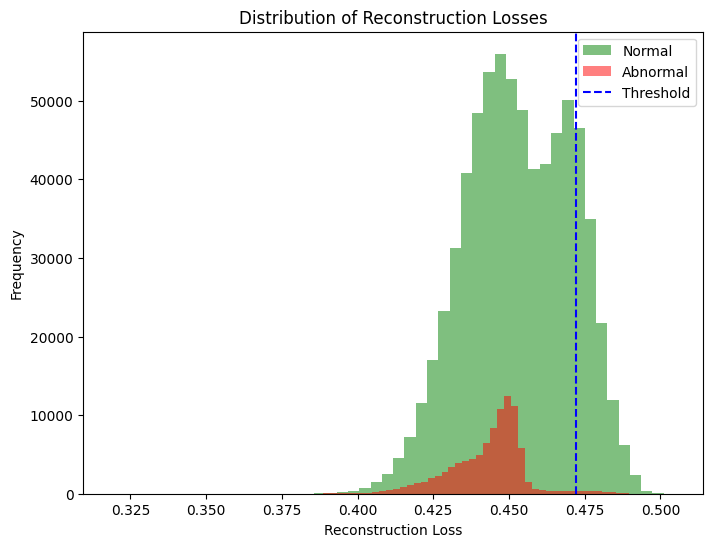

25000/25000 [==============================] - 19s 762us/step


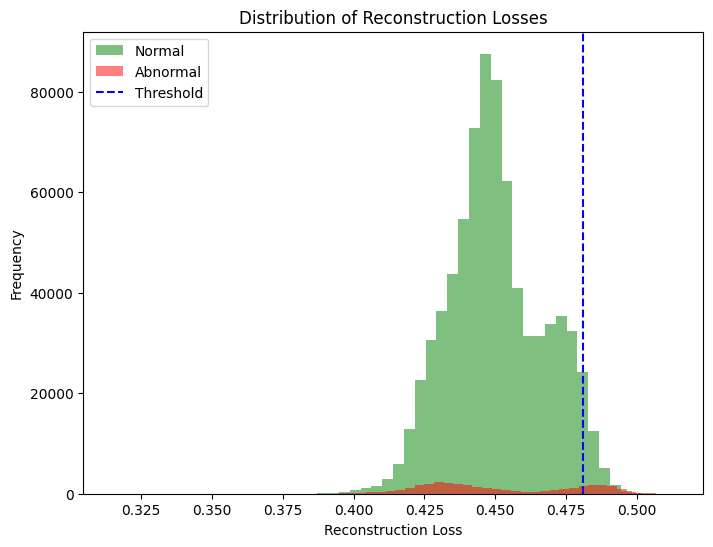

25000/25000 [==============================] - 20s 781us/step


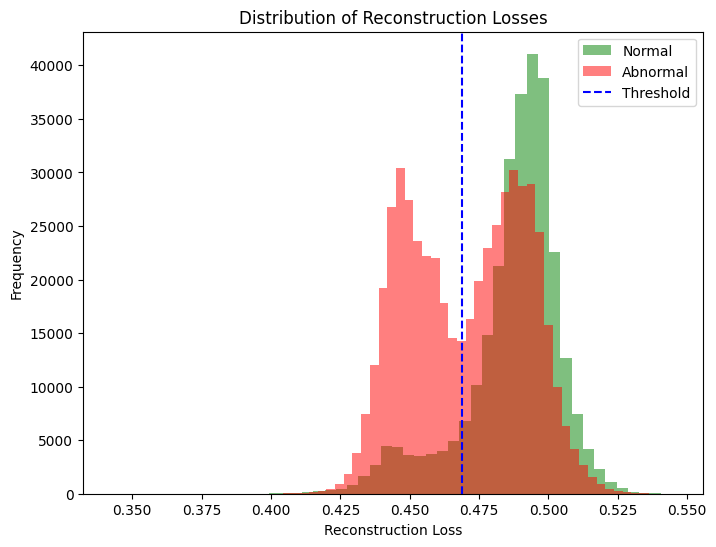

25000/25000 [==============================] - 20s 774us/step


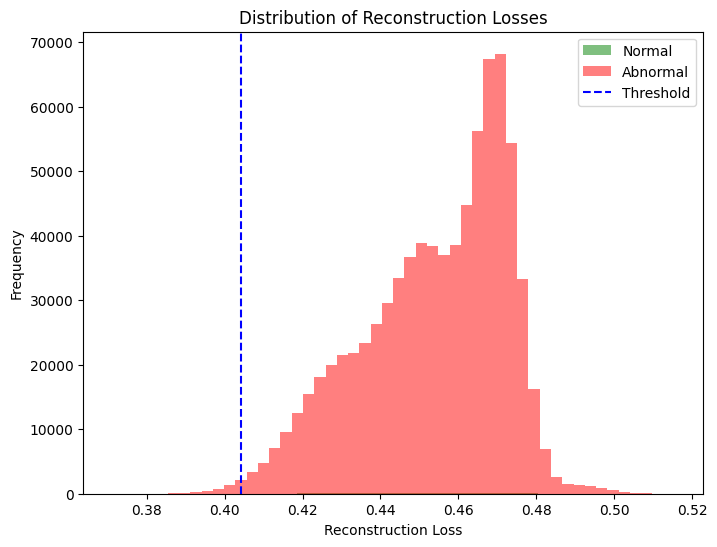

6250/6250 [==============================] - 5s 733us/step


In [48]:


def eval_on_VAE(train, test):
    model = VariationalAutoencoderClassifier(train.X, train.y, test.X, test.y)
    start = time()
    cpu_usage = psutil.cpu_percent(interval= None)
    model.fit()
    training_time_ = time()-start 
    y_pred = model.predict()
    y_true = test.y.to_numpy()
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    acc = (tn + tp) / (tn + fp + fn + tp)
    prec = tp / (tp + fp)
    rec = tp / (tp + fn) 
    f1 = 2 * prec * rec / (prec + rec)
    miss = fn / (fn + tp)
    return {
        "tp": tp,
        "tn": tn,
        "fp": fp,
        "fn": fn,
        "acc": acc,
        "prec": prec,
        "rec": rec,
        "f1": f1,
        "miss": miss,
        "training time":training_time_,
        "cpu usage":cpu_usage
    }, model


cicids_VAEresults, cicids_VAE = eval_on_VAE(*cicids)
nb15_VAEresults, nb15_VAE = eval_on_VAE(*nb15)
toniot_VAEresults, toniot_VAE = eval_on_VAE(*toniot)
botiot_VAEresults, botiot_VAE = eval_on_VAE(*botiot)




In [49]:
df_results_VAE = pd.DataFrame(columns=["Dataset", "Accuracy", "Precision", "Recall", "F1", "Miss Rate", "Training Time", "CPU Usage"])

dfs = []
for dataset_VAE in [
    ("CIC-IDS", cicids_VAEresults),
    ("UNSW-NB15", nb15_VAEresults),
    ("ToN-IoT", toniot_VAEresults),
    ("Bot-IoT", botiot_VAEresults),
]:
    data = {
        "Dataset": [dataset_VAE[0]],
        "Accuracy": [dataset_VAE[1]["acc"]],
        "Precision": [dataset_VAE[1]["prec"]],
        "Recall": [dataset_VAE[1]["rec"]],
        "F1": [dataset_VAE[1]["f1"]],
        "Miss Rate": [dataset_VAE[1]["miss"]],
        "Training Time": [dataset_VAE[1]["training time"]],
        "CPU Usage": [dataset_VAE[1]["cpu usage"]]
    }
    df = pd.DataFrame(data)
    dfs.append(df)

df_results_VAE = pd.concat(dfs, ignore_index=True)
print("-------------Using Variational Autoencoders----------------")
df_results_VAE

-------------Using Variational Autoencoders----------------


Dataset  Accuracy  Precision    Recall        F1  Miss Rate  \
0    CIC-IDS  0.742315   0.014736  0.017591  0.016038   0.982409   
1  UNSW-NB15  0.930120   0.190304  0.230586  0.208517   0.769414   
2    ToN-IoT  0.389010   0.522374  0.535752  0.528979   0.464248   
3    Bot-IoT  0.991225   0.996451  0.994736  0.995593   0.005264   

   Training Time  CPU Usage  
0      34.129240        4.3  
1      33.762607        8.4  
2      34.547797        8.3  
3      34.630622        8.4

# Cross dataset Evaluation

In [13]:
# Compute cross f1 score between datasets (ie, model trained on one dataset and evaluated on another)

def cross_f1_score(model, test: Dataset) -> float:
    y_pred = model.predict()
    y_true = test.y.to_numpy()
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    f1 = 2 * prec * rec / (prec + rec)
    return f1

In [14]:


cross_comp_BAE_df = pd.DataFrame(columns=["Trained on", "CIC-IDS F1", "UNSW-NB15 F1", "ToN-IoT F1", "Bot-IoT F1"])
cross_comp_BAE_df["Trained on"] = ["CIC-IDS", "UNSW-NB15", "ToN-IoT", "Bot-IoT"]

for model in [
    ("CIC-IDS", cicids_BAE), 
    ("UNSW-NB15", nb15_BAE),
    ("ToN-IoT", toniot_BAE),
    ("Bot-IoT", botiot_BAE),
]:
    for dataset in [
        ("CIC-IDS", cicids[1]),
        ("UNSW-NB15", nb15[1]),
        ("ToN-IoT", toniot[1]),
        ("Bot-IoT", botiot[1]),
    ]:
        
        cross_comp_BAE_df.loc[cross_comp_BAE_df["Trained on"] == model[0], f"{dataset[0]} F1"] = cross_f1_score(model[1], dataset[1])

print("-------------Using Basic Autoencoders----------------")
cross_comp_BAE_df

6250/6250 [==============================] - 4s 631us/step
-------------Using Basic Autoencoders----------------


Trained on CIC-IDS F1 UNSW-NB15 F1 ToN-IoT F1 Bot-IoT F1
0    CIC-IDS   0.499599      0.06011   0.199019   0.210721
1  UNSW-NB15   0.067406     0.366444    0.08778   0.091348
2    ToN-IoT   0.191092     0.074009   0.731506   0.661365
3    Bot-IoT   0.213297     0.076775    0.78077   0.998212

In [29]:
cross_comp_AE_df = pd.DataFrame(columns=["Trained on", "CIC-IDS F1", "UNSW-NB15 F1", "ToN-IoT F1", "Bot-IoT F1"])
cross_comp_AE_df["Trained on"] = ["CIC-IDS", "UNSW-NB15", "ToN-IoT", "Bot-IoT"]

for model in [
    ("CIC-IDS", cicids_AE), 
    ("UNSW-NB15", nb15_AE),
    ("ToN-IoT", toniot_AE),
    ("Bot-IoT", botiot_AE),
]:
    for dataset in [
        ("CIC-IDS", cicids[1]),
        ("UNSW-NB15", nb15[1]),
        ("ToN-IoT", toniot[1]),
        ("Bot-IoT", botiot[1]),
    ]:
        
        cross_comp_AE_df.loc[cross_comp_AE_df["Trained on"] == model[0], f"{dataset[0]} F1"] = cross_f1_score(model[1], dataset[1])

print("-------------Using Stacked Autoencoders----------------")
cross_comp_AE_df

 214/6250 [>.............................] - ETA: 4s

2023-06-19 18:08:21.965340: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [200000,39]
	 [[{{node Placeholder/_10}}]]
2023-06-19 18:08:21.965609: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [200000,39]
	 [[{{node Placeholder/_10}}]]


 451/6250 [=>............................] - ETA: 3s

 208/6250 [..............................] - ETA: 4s

2023-06-19 18:08:27.489672: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [200000,39]
	 [[{{node Placeholder/_10}}]]
2023-06-19 18:08:27.489956: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [200000,39]
	 [[{{node Placeholder/_10}}]]


 207/6250 [..............................] - ETA: 4s

2023-06-19 18:08:32.939415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [200000,39]
	 [[{{node Placeholder/_10}}]]
2023-06-19 18:08:32.939731: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [200000,39]
	 [[{{node Placeholder/_10}}]]


 229/6250 [>.............................] - ETA: 3s

2023-06-19 18:08:38.781799: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [200000,39]
	 [[{{node Placeholder/_10}}]]
2023-06-19 18:08:38.782127: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [200000,39]
	 [[{{node Placeholder/_10}}]]


 204/6250 [..............................] - ETA: 4s

2023-06-19 18:08:44.019649: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [200000,39]
	 [[{{node Placeholder/_10}}]]
2023-06-19 18:08:44.019975: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [200000,39]
	 [[{{node Placeholder/_10}}]]


 203/6250 [..............................] - ETA: 4s

2023-06-19 18:08:49.803941: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [200000,39]
	 [[{{node Placeholder/_10}}]]
2023-06-19 18:08:49.804240: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [200000,39]
	 [[{{node Placeholder/_10}}]]


 204/6250 [..............................] - ETA: 4s

2023-06-19 18:08:55.659278: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [200000,39]
	 [[{{node Placeholder/_10}}]]
2023-06-19 18:08:55.659569: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [200000,39]
	 [[{{node Placeholder/_10}}]]


 204/6250 [..............................] - ETA: 4s

2023-06-19 18:09:01.274955: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [200000,39]
	 [[{{node Placeholder/_10}}]]
2023-06-19 18:09:01.275240: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [200000,39]
	 [[{{node Placeholder/_10}}]]


 218/6250 [>.............................] - ETA: 4s

2023-06-19 18:09:06.805573: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [200000,39]
	 [[{{node Placeholder/_10}}]]
2023-06-19 18:09:06.805860: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [200000,39]
	 [[{{node Placeholder/_10}}]]


 195/6250 [..............................] - ETA: 4s

2023-06-19 18:09:12.291762: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [200000,39]
	 [[{{node Placeholder/_10}}]]
2023-06-19 18:09:12.292059: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [200000,39]
	 [[{{node Placeholder/_10}}]]


 199/6250 [..............................] - ETA: 4s

2023-06-19 18:09:17.774273: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [200000,39]
	 [[{{node Placeholder/_10}}]]
2023-06-19 18:09:17.774560: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [200000,39]
	 [[{{node Placeholder/_10}}]]


 202/6250 [..............................] - ETA: 4s

2023-06-19 18:09:23.287240: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [200000,39]
	 [[{{node Placeholder/_10}}]]
2023-06-19 18:09:23.287553: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [200000,39]
	 [[{{node Placeholder/_10}}]]


 201/6250 [..............................] - ETA: 4s

2023-06-19 18:09:29.041942: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [200000,39]
	 [[{{node Placeholder/_10}}]]
2023-06-19 18:09:29.042218: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [200000,39]
	 [[{{node Placeholder/_10}}]]


 199/6250 [..............................] - ETA: 4s

2023-06-19 18:09:34.949767: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [200000,39]
	 [[{{node Placeholder/_10}}]]
2023-06-19 18:09:34.950047: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [200000,39]
	 [[{{node Placeholder/_10}}]]


 202/6250 [..............................] - ETA: 4s

2023-06-19 18:09:40.706189: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [200000,39]
	 [[{{node Placeholder/_10}}]]
2023-06-19 18:09:40.706473: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [200000,39]
	 [[{{node Placeholder/_10}}]]


 204/6250 [..............................] - ETA: 4s

2023-06-19 18:09:46.604906: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [200000,39]
	 [[{{node Placeholder/_10}}]]
2023-06-19 18:09:46.605193: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype double and shape [200000,39]
	 [[{{node Placeholder/_10}}]]


6250/6250 [==============================] - 4s 704us/step
-------------Using Autoencoders----------------


Trained on CIC-IDS F1 UNSW-NB15 F1 ToN-IoT F1 Bot-IoT F1
0    CIC-IDS   0.499979     0.060022   0.198926   0.210561
1  UNSW-NB15     0.0669     0.367408   0.087403   0.090928
2    ToN-IoT   0.190923     0.074084   0.732636   0.662696
3    Bot-IoT   0.213297     0.076775    0.78077   0.998212

In [21]:


cross_comp_DAE_df = pd.DataFrame(columns=["Trained on", "CIC-IDS F1", "UNSW-NB15 F1", "ToN-IoT F1", "Bot-IoT F1"])
cross_comp_DAE_df["Trained on"] = ["CIC-IDS", "UNSW-NB15", "ToN-IoT", "Bot-IoT"]

for model in [
    ("CIC-IDS", cicids_DAE), 
    ("UNSW-NB15", nb15_DAE),
    ("ToN-IoT", toniot_DAE),
    ("Bot-IoT", botiot_DAE),
]:
    for dataset in [
        ("CIC-IDS", cicids[1]),
        ("UNSW-NB15", nb15[1]),
        ("ToN-IoT", toniot[1]),
        ("Bot-IoT", botiot[1]),
    ]:
        
        cross_comp_DAE_df.loc[cross_comp_DAE_df["Trained on"] == model[0], f"{dataset[0]} F1"] = cross_f1_score(model[1], dataset[1])

print("-------------Using Denoising Autoencoders----------------")
cross_comp_DAE_df

6250/6250 [==============================] - 4s 627us/step
-------------Using Denoising Autoencoders----------------


Trained on CIC-IDS F1 UNSW-NB15 F1 ToN-IoT F1 Bot-IoT F1
0    CIC-IDS   0.499747     0.060043   0.199016   0.210737
1  UNSW-NB15   0.067133     0.366716   0.087658   0.091229
2    ToN-IoT   0.190943     0.074085   0.732625   0.662688
3    Bot-IoT   0.213297     0.076775    0.78077   0.998212

In [50]:


cross_comp_VAE_df = pd.DataFrame(columns=["Trained on", "CIC-IDS F1", "UNSW-NB15 F1", "ToN-IoT F1", "Bot-IoT F1"])
cross_comp_VAE_df["Trained on"] = ["CIC-IDS", "UNSW-NB15", "ToN-IoT", "Bot-IoT"]

for model in [
    ("CIC-IDS", cicids_VAE), 
    ("UNSW-NB15", nb15_VAE),
    ("ToN-IoT", toniot_VAE),
    ("Bot-IoT", botiot_VAE),
]:
    for dataset in [
        ("CIC-IDS", cicids[1]),
        ("UNSW-NB15", nb15[1]),
        ("ToN-IoT", toniot[1]),
        ("Bot-IoT", botiot[1]),
    ]:
        
        cross_comp_VAE_df.loc[cross_comp_VAE_df["Trained on"] == model[0], f"{dataset[0]} F1"] = cross_f1_score(model[1], dataset[1])

print("-------------Using Variational Autoencoders----------------")
cross_comp_VAE_df

6250/6250 [==============================] - 5s 769us/step
-------------Using Variational Autoencoders----------------


Trained on CIC-IDS F1 UNSW-NB15 F1 ToN-IoT F1 Bot-IoT F1
0    CIC-IDS   0.015112     0.066273   0.232677   0.248539
1  UNSW-NB15   0.068189     0.205309   0.088219   0.091947
2    ToN-IoT   0.202215     0.075835   0.528436   0.792128
3    Bot-IoT   0.213099     0.076803   0.779321   0.995774